In [93]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [94]:
train = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")

In [95]:
test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [97]:
train.duplicated().sum()

0

It looks like there are no duplicates in this dataset. 

In [98]:
cat = train.select_dtypes(include='object')

cat.apply(lambda x: x.nunique())

class                    2
cap-shape               74
cap-surface             83
cap-color               78
does-bruise-or-bleed    26
gill-attachment         78
gill-spacing            48
gill-color              63
stem-root               38
stem-surface            60
stem-color              59
veil-type               22
veil-color              24
has-ring                23
ring-type               40
spore-print-color       32
habitat                 52
season                   4
dtype: int64

<Axes: >

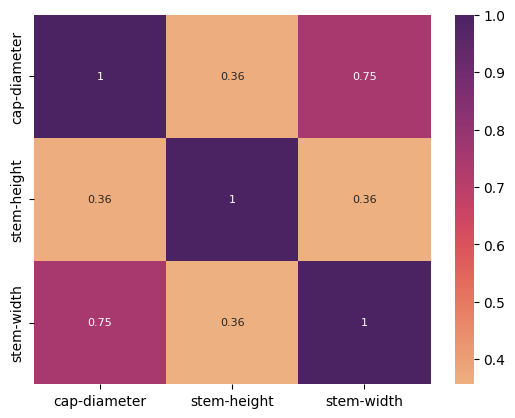

In [99]:
import seaborn as sns 
import matplotlib.pyplot as plt 

numeric = train.select_dtypes(include="float64").corr()
sns.heatmap(numeric, cmap="flare", annot=True, annot_kws={"size": 8})

It seems like the cap-diameter and stem-width are correlated, which means we may have to watch out for multicollinearity.

In [100]:
train.isna().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

# PREPROCESSING

First, we drop columns with excessive amounts of missing features.

In [101]:
features_to_drop = ['id', 'cap-surface', 'gill-attachment', 'gill-spacing', 'stem-root', 
                    'stem-surface', 'veil-type', 'veil-color', 'ring-type', 'spore-print-color',
                    'habitat', 'stem-color', 'gill-color', 'cap-color', 'cap-shape', 'does-bruise-or-bleed',
                    'has-ring']

train = train.drop(features_to_drop, axis=1)

In [102]:
test_sub = test.drop(features_to_drop, axis=1)

In [103]:
X = train.drop(['class'], axis=1)
y = train['class']

For now, we'll simply encode the season, as the other features simply have too many categories.

In [104]:
X = pd.get_dummies(X, columns=['season'], drop_first=True)

In [105]:
test_sub = pd.get_dummies(test_sub, columns=['season'], drop_first=True)

In [106]:
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

# Select numerical features 
num_features = X.select_dtypes(include='float64').columns

# Impute median to all numerical features 
num_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy='median')),
    ("scale", RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
    ]
)

X = preprocessor.fit_transform(X)


In [112]:
test_sub = preprocessor.fit_transform(test_sub)

# CV

We're simply going to attempt logistic regression for what will be our "null model", our model to compare against. Because this dataset is fairly large, we have chosen to cross-validate over 5 folds to reduce computational strain.

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef

model = LogisticRegression() 

folds = 5
skfolds = StratifiedKFold(n_splits=folds)

total_mcc = []

for train_index, test_index, in skfolds.split(X, y):
    X_train_folds, y_train_folds = X[train_index], y[train_index]
    X_test_folds, y_test_folds = X[test_index], y[test_index]
    
    model.fit(X_train_folds, y_train_folds)
    y_pred_folds = model.predict(X_test_folds)
    
    mcc = matthews_corrcoef(y_test_folds, y_pred_folds)
    total_mcc.append(mcc)

In [108]:
total_mcc

[0.16087844495866185,
 0.16207151275614598,
 0.16031848370808036,
 0.16025558304342358,
 0.16077823487980367]

In [109]:
model.fit(X, y)

LogisticRegression()

In [110]:
test_sub.columns

Index(['cap-diameter', 'stem-height', 'stem-width', 'season_s', 'season_u',
       'season_w'],
      dtype='object')

In [113]:
pred_class = model.predict(test_sub)

test['class'] = pred_class 

submission = test[['id', 'class']]

In [114]:
submission.to_csv('submission.csv', index=False)